This notebook explores convolutional neural networks for text, using the keras `Sequential` and `Functional` interfaces.
<br>

Before getting started, install the pydot library

```sh
conda install pydot=1.3.0
```

In [1]:
import keras
import numpy as np
from sklearn import preprocessing
from keras.layers import Dense, Input, Embedding, GlobalMaxPooling1D, Conv1D, Concatenate, Dropout
from keras.models import Model, Sequential
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
def load_embeddings(filename, max_vocab_size):

    vocab={}
    embeddings=[]
    with open(filename) as file:
        
        cols=file.readline().split(" ")
        num_words=int(cols[0])
        size=int(cols[1])
        embeddings.append(np.zeros(size))  # 0 = 0 padding if needed
        embeddings.append(np.zeros(size))  # 1 = UNK
        vocab["_0_"]=0
        vocab["_UNK_"]=1
        
        for idx,line in enumerate(file):

            if idx+2 >= max_vocab_size:
                break

            cols=line.rstrip().split(" ")
            val=np.array(cols[1:])
            word=cols[0]
            
            embeddings.append(val)
            vocab[word]=idx+2

    return np.array(embeddings), vocab, size

In [3]:
def read_data(filename, vocab):
    X=[]
    Y=[]
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols=line.rstrip().split("\t")
            label=cols[0]
            # assumes text is already tokenized
            text=cols[1].split(" ")
            X.append(cols[1])
            Y.append(label)
    return X, Y

In [4]:
def get_word_ids(docs, vocab, max_length=1000):
    
    doc_ids=[]
    
    for doc in docs:
        wids=[]

        for token in doc[:max_length]:
            val = vocab[token.lower()] if token.lower() in vocab else 1
            wids.append(val)
        
        # pad each document to constant width
        for i in range(len(wids),max_length):
            wids.append(0)

        doc_ids.append(wids)

    return np.array(doc_ids)

In [5]:
embeddings, vocab, embedding_size=load_embeddings("../data/glove.42B.300d.50K.w2v.txt", 100000)

In [6]:
# Change this to the directory with your data (from the CheckData_TODO.ipynb exercise).  
# The directory should contain train.tsv, dev.tsv and test.tsv
directory="../data/lmrd"

In [7]:
trainText, trainY=read_data("%s/train.tsv" % directory, vocab)
devText, devY=read_data("%s/dev.tsv" % directory, vocab)

In [8]:
trainX = get_word_ids(trainText, vocab, max_length=200)
devX = get_word_ids(devText, vocab, max_length=200)

In [9]:
le = preprocessing.LabelEncoder()
le.fit(trainY)
Y_train=np.array(le.transform(trainY))
Y_dev=np.array(le.transform(devY))

In [10]:
def cnn_sequential(embeddings, vocab_size, word_embedding_dim):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=word_embedding_dim, weights=[embeddings], trainable=False))
    model.add(Conv1D(filters=50, kernel_size=2, strides=1, padding="same", activation="tanh", name="CNN_bigram"))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

    return model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         15000600  
_________________________________________________________________
CNN_bigram (Conv1D)          (None, None, 50)          30050     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 15,030,701
Trainable params: 30,101
Non-trainable params: 15,000,600
____

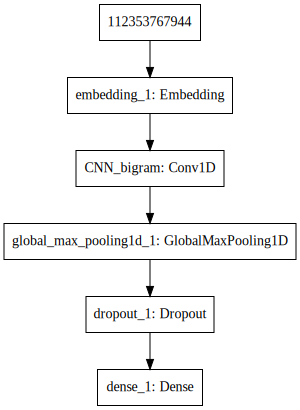

In [11]:
cnn_sequential_model=cnn_sequential(embeddings, len(vocab), embedding_size)
print (cnn_sequential_model.summary())
SVG(model_to_dot(cnn_sequential_model).create(prog='dot', format='svg'))

In [12]:
def cnn(embeddings, vocab_size, word_embedding_dim):

    word_sequence_input = Input(shape=(None,), dtype='int32')
    
    word_embedding_layer = Embedding(vocab_size,
                                    word_embedding_dim,
                                    weights=[embeddings],
                                    trainable=False)

    
    embedded_sequences = word_embedding_layer(word_sequence_input)
    
    cnn2=Conv1D(filters=50, kernel_size=2, strides=1, padding="same", activation="tanh", name="CNN_bigram")(embedded_sequences)
    cnn3=Conv1D(filters=50, kernel_size=3, strides=1, padding="same", activation="tanh", name="CNN_trigram")(embedded_sequences)
    cnn4=Conv1D(filters=50, kernel_size=4, strides=1, padding="same", activation="tanh", name="CNN_4gram")(embedded_sequences)

    # max pooling over all words in the document
    maxpool2=GlobalMaxPooling1D()(cnn2)
    maxpool3=GlobalMaxPooling1D()(cnn3)
    maxpool4=GlobalMaxPooling1D()(cnn4)

    x=Concatenate()([maxpool2, maxpool3, maxpool4])

    x=Dropout(0.2)(x)
    x=Dense(50)(x)
    x=Dense(1, activation="sigmoid")(x)

    model = Model(inputs=word_sequence_input, outputs=x)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 300)    15000600    input_1[0][0]                    
__________________________________________________________________________________________________
CNN_bigram (Conv1D)             (None, None, 50)     30050       embedding_2[0][0]                
__________________________________________________________________________________________________
CNN_trigram (Conv1D)            (None, None, 50)     45050       embedding_2[0][0]                
__________________________________________________________________________________________________
CNN_4gram 

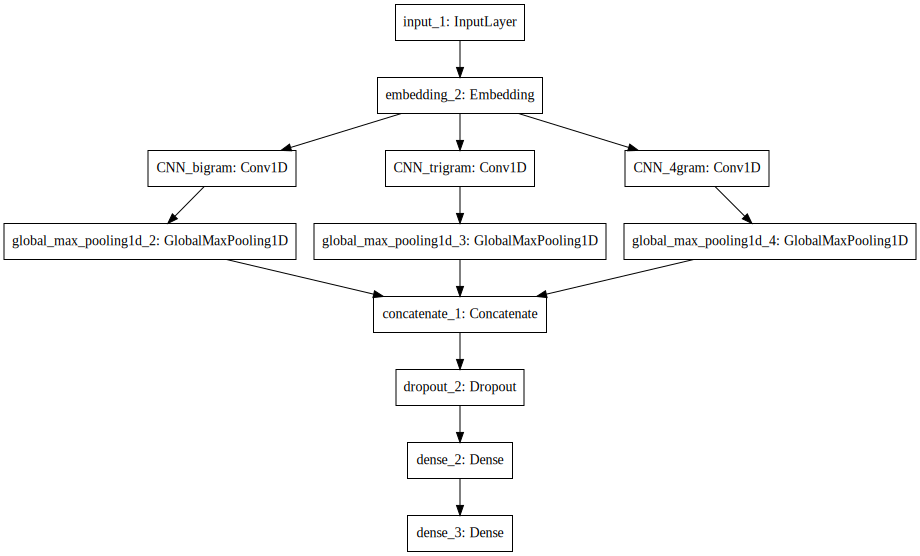

In [13]:
cnn_functional_model=cnn(embeddings, len(vocab), embedding_size)
print (cnn_functional_model.summary())
SVG(model_to_dot(cnn_functional_model).create(prog='dot', format='svg'))

In [14]:
model=cnn_functional_model
model.fit(trainX, Y_train, 
            validation_data=(devX, Y_dev),
            epochs=10, batch_size=128)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 80s 4ms/step - loss: 0.6926 - acc: 0.5623 - val_loss: 0.6527 - val_acc: 0.6174
Epoch 2/30
20000/20000 [==============================] - 73s 4ms/step - loss: 0.6344 - acc: 0.6351 - val_loss: 0.6334 - val_acc: 0.6310
Epoch 3/30
20000/20000 [==============================] - 80s 4ms/step - loss: 0.6098 - acc: 0.6632 - val_loss: 0.6452 - val_acc: 0.6240
Epoch 4/30
20000/20000 [==============================] - 82s 4ms/step - loss: 0.5962 - acc: 0.6791 - val_loss: 0.5981 - val_acc: 0.6768
Epoch 5/30
20000/20000 [==============================] - 75s 4ms/step - loss: 0.5876 - acc: 0.6889 - val_loss: 0.6054 - val_acc: 0.6686
Epoch 6/30
20000/20000 [==============================] - 87s 4ms/step - loss: 0.5802 - acc: 0.6911 - val_loss: 0.6251 - val_acc: 0.6522
Epo